# CIFAR10 Image Classification

Fast-forward to 2012, and we move on to the deeper and more modern AlexNet architecture. We will use the CIFAR10 dataset that uses 60,000 ImageNet samples, compressed to 32x32 pixel resolution (from the original 224x224), but still with three color channels. There are only 10 of the original 1,000 classes. See the notebook cifar10_image_classification for implementation details; we will skip here over some repetitive steps. 

## Run inside docker container for GPU acceleration

See [tensorflow guide](https://www.tensorflow.org/install/docker) and more detailed [instructions](https://blog.sicara.com/tensorflow-gpu-opencv-jupyter-docker-10705b6cd1d)

## Imports

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

## Load CIFAR-10 Data

CIFAR10 can also be downloaded from keras, and we similarly rescale the pixel values and one-hot encode the ten class labels. 

In [5]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Visualize the First 30 Training Images

In [6]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [7]:
num_classes = len(cifar10_labels)

In [8]:
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

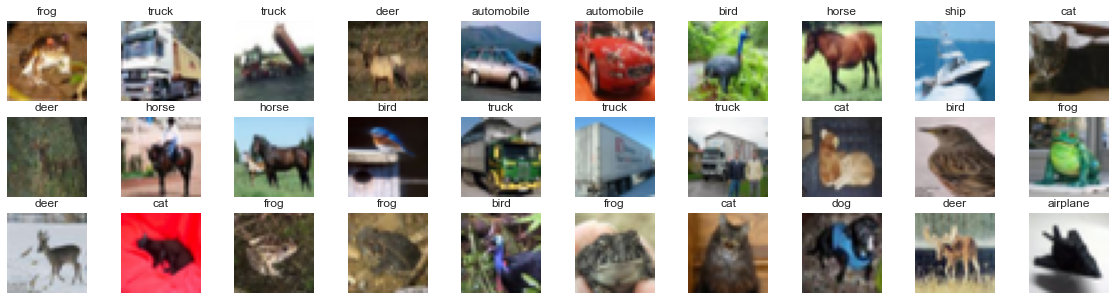

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])

### Rescale the Images

In [10]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### Train-Test split

In [11]:
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

In [12]:
# shape of training set
X_train.shape

(45000, 32, 32, 3)

In [13]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


## Feedforward Neural Network

We first train a two-layer feedforward network on 50,000 training samples for training for 20 epochs to achieve a test accuracy of 44.22%. We also experiment with a three-layer convolutional net with 500K parameters for 67.07% test accuracy.

### Model Architecture 

In [14]:
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

In [15]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1000)              3073000   
_________________________________________________________________
droput_1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 3,590,642
Trainable params: 3,590,642
Non-trainable params: 0
______________________________________________

### Compile the Model 

In [16]:
mlp.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [17]:
mlp_path = 'models/cifar10.mlp.weights.best.hdf5'

In [18]:
checkpointer = ModelCheckpoint(filepath=mlp_path,
                               verbose=1,
                               save_best_only=True)

In [19]:
tensorboard = TensorBoard(log_dir='./logs/mlp',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model 

In [21]:
batch_size = 32
epochs = 100

In [22]:
mlp_history = mlp.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=1,
                      shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
44672/45000 [============================>.] - ETA: 0s - loss: 1.9779 - accuracy: 0.2778
Epoch 00001: val_loss improved from inf to 1.80550, saving model to models/cifar10.mlp.weights.best.hdf5
45000/45000 [==============================] - 4s 79us/sample - loss: 1.9771 - accuracy: 0.2780 - val_loss: 1.8055 - val_accuracy: 0.3614
Epoch 2/100
44448/45000 [============================>.] - ETA: 0s - loss: 1.8390 - accuracy: 0.3258
Epoch 00002: val_loss improved from 1.80550 to 1.75038, saving model to models/cifar10.mlp.weights.best.hdf5
45000/45000 [==============================] - 3s 70us/sample - loss: 1.8391 - accuracy: 0.3256 - val_loss: 1.7504 - val_accuracy: 0.3754
Epoch 3/100
44704/45000 [============================>.] - ETA: 0s - loss: 1.8027 - accuracy: 0.3417
Epoch 00003: val_loss improved from 1.75038 to 1.72096, saving model to models/cifar10.mlp.weights.best.hdf5
45000/45000 [==============================] - 3s

45000/45000 [==============================] - 3s 67us/sample - loss: 1.6051 - accuracy: 0.4206 - val_loss: 1.5866 - val_accuracy: 0.4298
Epoch 27/100
44544/45000 [============================>.] - ETA: 0s - loss: 1.6032 - accuracy: 0.4217
Epoch 00027: val_loss did not improve from 1.55014
45000/45000 [==============================] - 3s 68us/sample - loss: 1.6032 - accuracy: 0.4219 - val_loss: 1.5835 - val_accuracy: 0.4318
Epoch 28/100
44448/45000 [============================>.] - ETA: 0s - loss: 1.6000 - accuracy: 0.4234
Epoch 00028: val_loss did not improve from 1.55014
45000/45000 [==============================] - 3s 66us/sample - loss: 1.6007 - accuracy: 0.4232 - val_loss: 1.5852 - val_accuracy: 0.4378
Epoch 29/100
44992/45000 [============================>.] - ETA: 0s - loss: 1.5977 - accuracy: 0.4260
Epoch 00029: val_loss did not improve from 1.55014
45000/45000 [==============================] - 3s 69us/sample - loss: 1.5977 - accuracy: 0.4260 - val_loss: 1.5564 - val_accura

Epoch 54/100
44576/45000 [============================>.] - ETA: 0s - loss: 1.5486 - accuracy: 0.4427
Epoch 00054: val_loss did not improve from 1.51591
45000/45000 [==============================] - 3s 73us/sample - loss: 1.5490 - accuracy: 0.4425 - val_loss: 1.5520 - val_accuracy: 0.4394
Epoch 55/100
44800/45000 [============================>.] - ETA: 0s - loss: 1.5501 - accuracy: 0.4436
Epoch 00055: val_loss did not improve from 1.51591
45000/45000 [==============================] - 3s 64us/sample - loss: 1.5501 - accuracy: 0.4438 - val_loss: 1.5496 - val_accuracy: 0.4612


### Plot CV Results

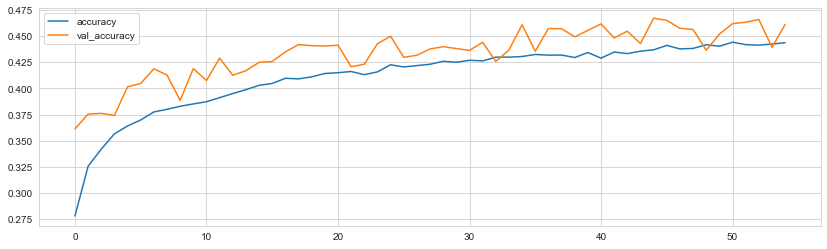

In [23]:
pd.DataFrame(mlp_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4))

### Load best model

In [24]:
# load the weights that yielded the best validation accuracy
mlp.load_weights(mlp_path)

### Test Classification Accuracy

In [25]:
# evaluate and print test accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(mlp_accuracy))

Test accuracy: 45.78%


## Convolutional Neural Network

In [26]:
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

### Model Architecture

In [27]:
cnn = Sequential([
    Conv2D(filters=16,
           kernel_size=2,
           padding='same',
           activation='relu',
           input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')
])

In [28]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 32, 32, 16)        208       
_________________________________________________________________
POOL1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 16, 16, 32)        2080      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 8, 8, 64)          8256      
_________________________________________________________________
POOL3 (MaxPooling2D)         (None, 4, 4, 64)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 4, 4, 64)          0

### Compile the Model

In [29]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [30]:
cnn_path = 'models/cifar10.cnn.weights.best.hdf5'

In [31]:
checkpointer = ModelCheckpoint(filepath=cnn_path,
                               verbose=1,
                               save_best_only=True)

In [32]:
tensorboard = TensorBoard(log_dir='./logs/cnn',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model

In [33]:
batch_size = 32
epochs = 100

In [34]:
cnn_history = cnn.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=2,
                      shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.23732, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 4s - loss: 1.5369 - accuracy: 0.4379 - val_loss: 1.2373 - val_accuracy: 0.5644
Epoch 2/100

Epoch 00002: val_loss improved from 1.23732 to 1.09505, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 3s - loss: 1.2280 - accuracy: 0.5632 - val_loss: 1.0950 - val_accuracy: 0.6104
Epoch 3/100

Epoch 00003: val_loss improved from 1.09505 to 1.01208, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 3s - loss: 1.1027 - accuracy: 0.6067 - val_loss: 1.0121 - val_accuracy: 0.6420
Epoch 4/100

Epoch 00004: val_loss improved from 1.01208 to 0.92431, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 3s - loss: 1.0282 - accuracy: 0.6344 - val_loss: 0.9243 - val_accuracy: 0.6684
Epoch 5/100

Epoch 00005: val_loss improved from 0.92431 to 0.89547, saving model to models/cif

### Plot CV Results

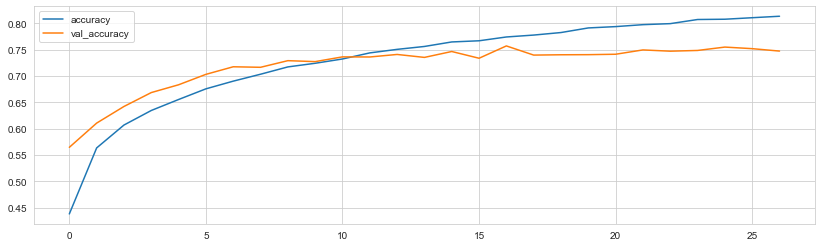

In [35]:
pd.DataFrame(cnn_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4));

### Load best model

In [36]:
cnn.load_weights(cnn_path)

### Test set accuracy

In [37]:
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(cnn_accuracy))

Accuracy: 74.51%


### Evaluate Predictions

In [38]:
y_hat = cnn.predict(X_test)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t-dl/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t-dl/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0, flags=flags)


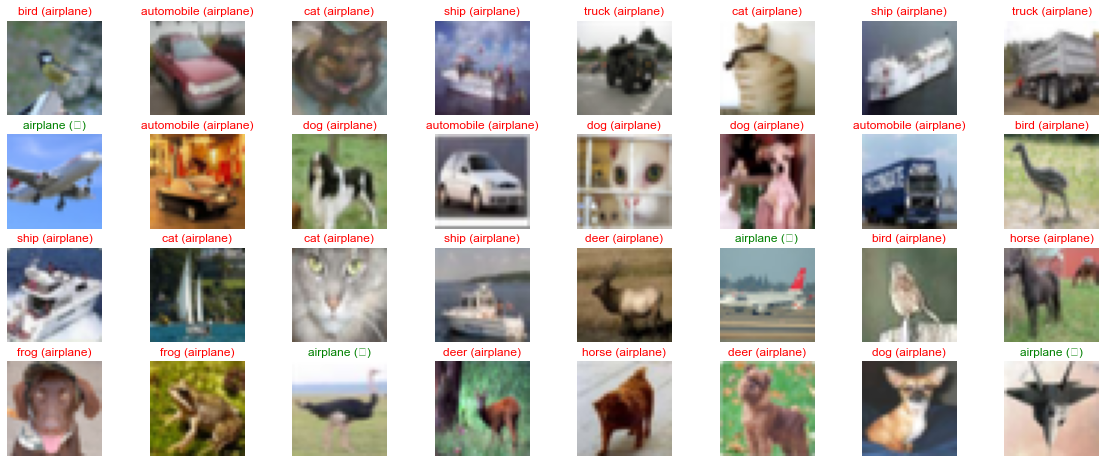

In [39]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx],
                                      cifar10_labels[true_idx]),
                     color='red')

## CNN with Image Augmentation

A common trick to enhance performance is to artificially increase the size of the training set by creating synthetic data. This involves randomly shifting or horizontally flipping the image, or introducing noise into the image.

### Create and configure augmented image generator

Keras includes an ImageDataGenerator for this purpose that we can configure and fit to the training data as follows:

In [40]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

In [41]:
# fit augmented image generator on data
datagen.fit(X_train)

### Visualize subset of training data

The result shows how the augmented images have been altered in various ways as expected:

In [42]:
n_images = 6
x_train_subset = X_train[:n_images]

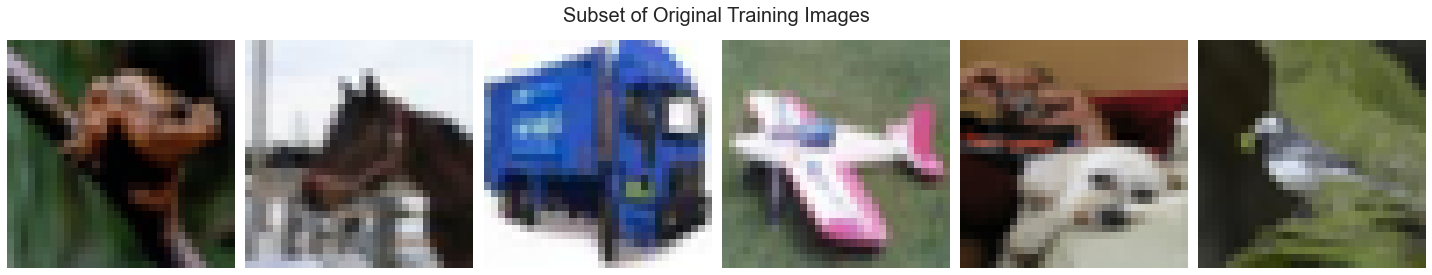

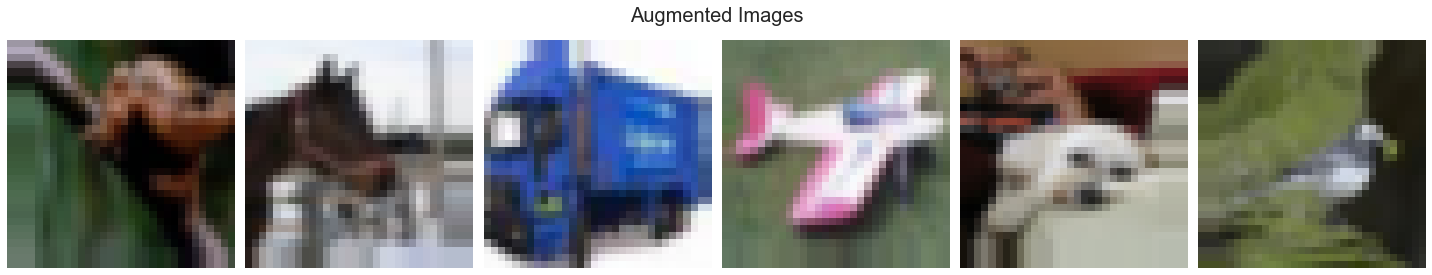

In [43]:
# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('images/original')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images,
                            shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break
fig.suptitle('Augmented Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('images/augmented')

### Define Callbacks

In [44]:
K.clear_session()

In [45]:
cnn_aug_path = 'models/cifar10.augmented.cnn.weights.best.hdf5'

In [46]:
checkpointer = ModelCheckpoint(filepath=cnn_aug_path,
                               verbose=1,
                               save_best_only=True)

In [47]:
tensorboard = TensorBoard(log_dir='./logs/cnn_aug',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

### Train Augmented Images

In [48]:
batch_size = 32
epochs = 100

In [49]:
cnn_aug_history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs,
                          validation_data=(X_valid, y_valid),
                          callbacks=[checkpointer, tensorboard, early_stopping],
                          verbose=2)

  ...
    to  
  ['...']
Train for 1406 steps, validate on 5000 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.81012, saving model to models/cifar10.augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 0.9893 - accuracy: 0.6548 - val_loss: 0.8101 - val_accuracy: 0.7224
Epoch 2/100

Epoch 00002: val_loss improved from 0.81012 to 0.78354, saving model to models/cifar10.augmented.cnn.weights.best.hdf5
1406/1406 - 14s - loss: 0.9583 - accuracy: 0.6655 - val_loss: 0.7835 - val_accuracy: 0.7318
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.78354
1406/1406 - 13s - loss: 0.9343 - accuracy: 0.6723 - val_loss: 0.8051 - val_accuracy: 0.7158
Epoch 4/100

Epoch 00004: val_loss improved from 0.78354 to 0.77505, saving model to models/cifar10.augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 0.9241 - accuracy: 0.6729 - val_loss: 0.7750 - val_accuracy: 0.7310
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.77505
1406/1406 - 13s - loss: 0.9125 - accurac

### Plot CV Result

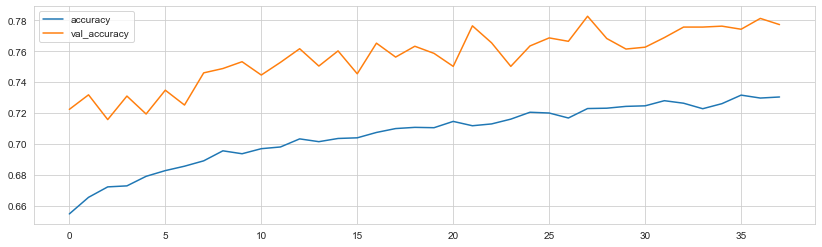

In [50]:
pd.DataFrame(cnn_aug_history.history)[['accuracy',
                                       'val_accuracy']].plot(figsize=(14, 4));

### Load best model

In [51]:
cnn.load_weights(cnn_aug_path)

### Test set accuracy

The test accuracy for the three-layer CNN improves markedly to 74.79% after training on the larger, augmented data.

In [52]:
cnn_aug_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(cnn_aug_accuracy))

Test Accuracy: 76.71%


## AlexNet

We also need to simplify the AlexNet architecture in response to the lower dimensionality of CIFAR10 images relative to the ImageNet samples used in the competition. We use the original number of filters but make them smaller (see notebook for implementation). The summary shows the five convolutional layers followed by two fully-connected layers with frequent use of batch normalization, for a total of 21.5 million parameters:

### Define Architecture

In [53]:
K.clear_session()

In [54]:
alexnet = Sequential([

    # 1st Convolutional Layer
    Conv2D(96, (3, 3),
           strides=(2, 2),
           activation='relu',
           padding='same',
           input_shape=input_shape,
           name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(5, 5),
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV3'),
    # 4th Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV4'),
    # 5th Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])

In [55]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 16, 16, 96)        2688      
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 8, 8, 96)          0         
_________________________________________________________________
NORM_1 (BatchNormalization)  (None, 8, 8, 96)          384       
_________________________________________________________________
CONV2 (Conv2D)               (None, 8, 8, 256)         614656    
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 3, 3, 256)         0         
_________________________________________________________________
NORM_2 (BatchNormalization)  (None, 3, 3, 256)         1024      
_________________________________________________________________
CONV3 (Conv2D)               (None, 3, 3, 384)         8

### Compile Model

In [56]:
alexnet.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

### Define Callbacks

In [57]:
alexnet_path = 'models/cifar10.augmented.alexnet.weights.best.hdf5'

In [58]:
checkpointer = ModelCheckpoint(filepath=alexnet_path,
                               verbose=1,
                               save_best_only=True)

In [59]:
tensorboard = TensorBoard(log_dir='./logs/alexnet',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

### Train Model

In [60]:
batch_size = 32
epochs = 100

In [61]:
alex_history = alexnet.fit(datagen.flow(X_train,
                                        y_train,
                                        batch_size=batch_size),
                           steps_per_epoch=X_train.shape[0] // batch_size,
                           epochs=epochs,
                           validation_data=(X_valid, y_valid),
                           callbacks=[checkpointer, tensorboard, early_stopping],
                           verbose=1)

  ...
    to  
  ['...']
Train for 1406 steps, validate on 5000 samples
Epoch 1/100
1404/1406 [============================>.] - ETA: 0s - loss: 1.7058 - accuracy: 0.3768
Epoch 00001: val_loss improved from inf to 1.46510, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
1406/1406 [==============================] - 16s 12ms/step - loss: 1.7055 - accuracy: 0.3770 - val_loss: 1.4651 - val_accuracy: 0.4550
Epoch 2/100
1403/1406 [============================>.] - ETA: 0s - loss: 1.3863 - accuracy: 0.5118
Epoch 00002: val_loss improved from 1.46510 to 1.34831, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
1406/1406 [==============================] - 16s 11ms/step - loss: 1.3861 - accuracy: 0.5117 - val_loss: 1.3483 - val_accuracy: 0.5336
Epoch 3/100
1403/1406 [============================>.] - ETA: 0s - loss: 1.2197 - accuracy: 0.5759
Epoch 00003: val_loss improved from 1.34831 to 1.15356, saving model to models/cifar10.augmented.alexnet.weights.best.h

Epoch 26/100
1401/1406 [============================>.] - ETA: 0s - loss: 0.5217 - accuracy: 0.8260
Epoch 00026: val_loss did not improve from 0.65051
1406/1406 [==============================] - 16s 11ms/step - loss: 0.5213 - accuracy: 0.8263 - val_loss: 0.7428 - val_accuracy: 0.7822
Epoch 27/100
1403/1406 [============================>.] - ETA: 0s - loss: 0.3877 - accuracy: 0.8699
Epoch 00027: val_loss did not improve from 0.65051
1406/1406 [==============================] - 16s 11ms/step - loss: 0.3876 - accuracy: 0.8698 - val_loss: 0.6794 - val_accuracy: 0.7920
Epoch 28/100
1405/1406 [============================>.] - ETA: 0s - loss: 0.3684 - accuracy: 0.8780
Epoch 00028: val_loss improved from 0.65051 to 0.62131, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
1406/1406 [==============================] - 16s 12ms/step - loss: 0.3682 - accuracy: 0.8781 - val_loss: 0.6213 - val_accuracy: 0.7934
Epoch 29/100
1403/1406 [============================>.] - ETA: 0s - lo

1406/1406 [==============================] - 15s 11ms/step - loss: 0.2272 - accuracy: 0.9271 - val_loss: 2.3987 - val_accuracy: 0.8070
Epoch 55/100
1402/1406 [============================>.] - ETA: 0s - loss: 0.2071 - accuracy: 0.9334
Epoch 00055: val_loss did not improve from 0.62131
1406/1406 [==============================] - 16s 11ms/step - loss: 0.2072 - accuracy: 0.9334 - val_loss: 0.9364 - val_accuracy: 0.8010
Epoch 56/100
1401/1406 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9155
Epoch 00056: val_loss did not improve from 0.62131
1406/1406 [==============================] - 15s 11ms/step - loss: 0.2629 - accuracy: 0.9156 - val_loss: 1.0767 - val_accuracy: 0.8082
Epoch 57/100
1402/1406 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.9392
Epoch 00057: val_loss did not improve from 0.62131
1406/1406 [==============================] - 16s 11ms/step - loss: 0.1907 - accuracy: 0.9391 - val_loss: 0.7930 - val_accuracy: 0.8054
Epoch 5

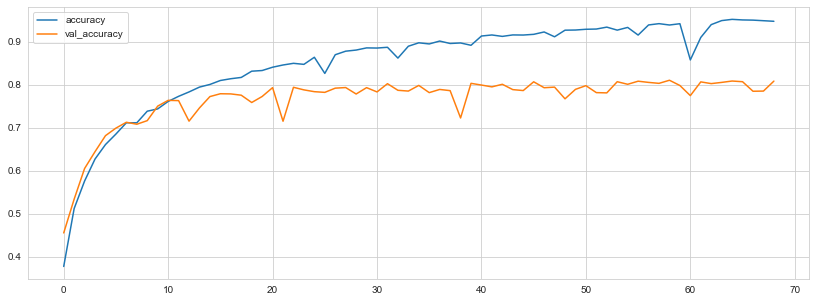

In [62]:
pd.DataFrame(alex_history.history)[['accuracy',
                               'val_accuracy']].plot(figsize=(14, 5))

In [63]:
alexnet.load_weights(alexnet_path)

After training for 20 episodes, each of which takes a little under 30 seconds on a single GPU, we obtain 76.84% test accuracy.

In [64]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(alex_accuracy))

Test Accuracy: 78.03%


## Compare Results

In [66]:
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
        'CNN': pd.Series(cnn_history.history['val_accuracy']),
        'CNN Aug.': pd.Series(cnn_aug_history.history['val_accuracy']),
        'Alex Net': pd.Series(alex_history.history['val_accuracy'])
    })
test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'CNN Aug.': cnn_aug_accuracy,
    'Alex Net': alex_accuracy
})

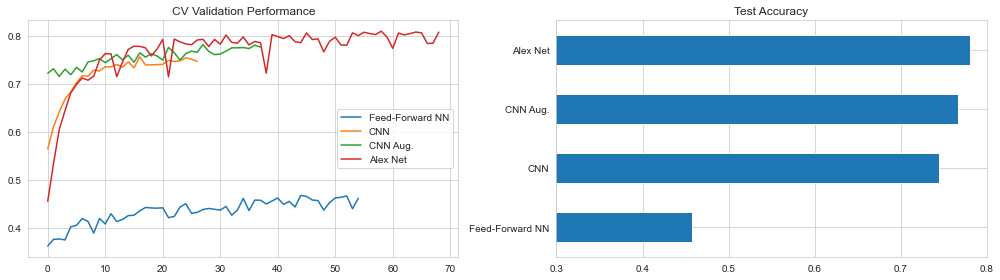

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
fig.savefig('figures/cifar_comparison', dpi=300);

## TensorBoard visualization

In [68]:
%load_ext tensorboard

In [69]:
%tensorboard --logdir logs/alexnet